In [1]:
import numpy as np
from brian2.only import *
import matplotlib.pyplot as plt
import seaborn as sns
import plot_utils as pu
import scipy.stats as stats
import deepdish as dd

from digest import conds

import conf.isi5_500 as cfg

In [2]:
_ = dd.io.load('distance.h5')
disthist_initial = _['disthist_initial']
distrough_initial = _['distrough_initial']
disthist_steady = _['disthist_steady']
fine_TA_steady = _['fine_TA_steady']
fine_STD_steady = _['fine_STD_steady']
distrough_steady_nets = _['distrough_steady_nets']
rough_TA_steady_nets = _['rough_TA_steady_nets']
rough_STD_steady_nets = _['rough_STD_steady_nets']
histbase = _['histbase']
roughbase = _['roughbase']
distconf = _['distconf']

In [3]:
conds = ['dev', 'msc', 'std']  # Invert for presentation purposes.

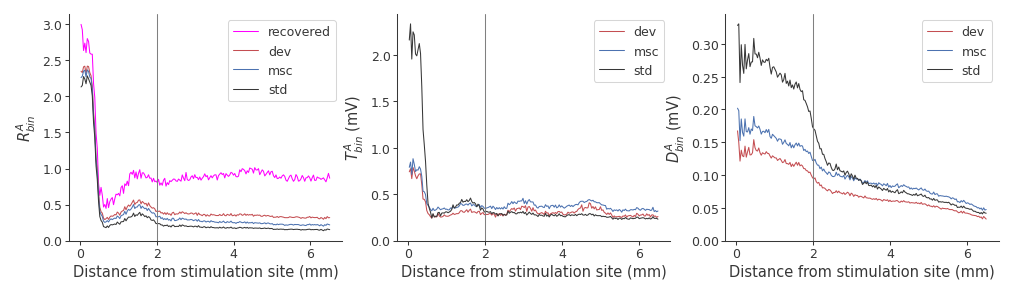

In [4]:
def panel_raw_lines(ax, kind='hist'):
    data = {'hist': disthist_steady, 'TA': fine_TA_steady, 'STD': fine_STD_steady}[kind]
    divisor = 1
    if kind == 'hist':
        ax.plot(distconf['full']['edges'][1:], disthist_initial, color='magenta', label='recovered')
    elif kind=='TA':
        divisor = mV
    for cond in ('dev', 'msc', 'std'):
        ax.plot(distconf['full']['edges'][1:], data[cond] / divisor, color=pu.colors[cond], label=cond)
    for edge in distconf['rough']['edges'][1:-1]:
        ax.axvline(edge, color='grey')
    ax.legend()
    ax.set_xlabel('Distance from stimulation site (mm)')
    ax.set_ylabel({
        'hist': '$R^A_{bin}$',
        'TA': '$T^A_{bin}$ (mV)',
        'STD': '$D^A_{bin}$ (mV)'}
        [kind])
    ax.set_ylim(bottom=0)
    sns.despine(ax=ax)

fig, axs = plt.subplots(1, 3, figsize=(8,2), dpi=150)
for ax, kind in zip(axs, ('hist', 'TA', 'STD')):
    panel_raw_lines(ax, kind)

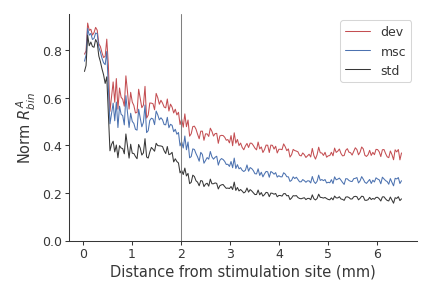

In [5]:
def panel_frac_hist_lines(ax):
    for cond in conds:
        ax.plot(distconf['full']['edges'][1:], disthist_steady[cond] / disthist_initial, color=pu.colors[cond], label=cond)
    for edge in distconf['rough']['edges'][1:-1]:
        ax.axvline(edge, color='grey')
    ax.legend()
    ax.set_xlabel('Distance from stimulation site (mm)')
    ax.set_ylabel('Norm $R^A_{bin}$')
    ax.set_ylim(bottom=0)
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(3,2), dpi=150)
panel_frac_hist_lines(ax)

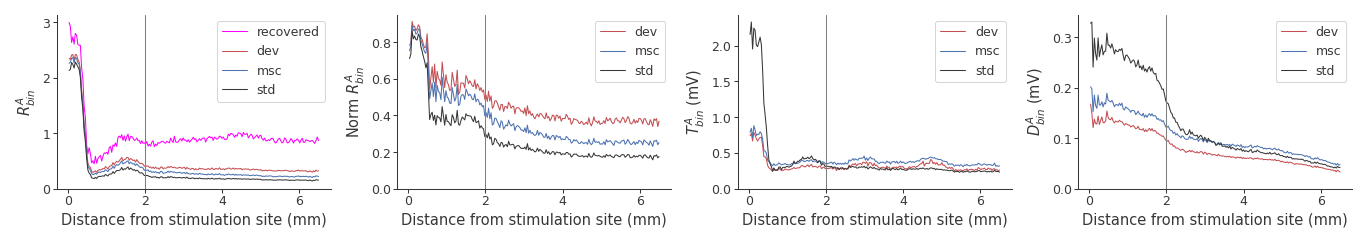

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(9,1.5), dpi=150, layout='constrained')
fig.patch.set_facecolor('w')
for ax, kind in zip(axs[[0,2,3]], ('hist', 'TA', 'STD')):
    panel_raw_lines(ax, kind)
panel_frac_hist_lines(axs[1])

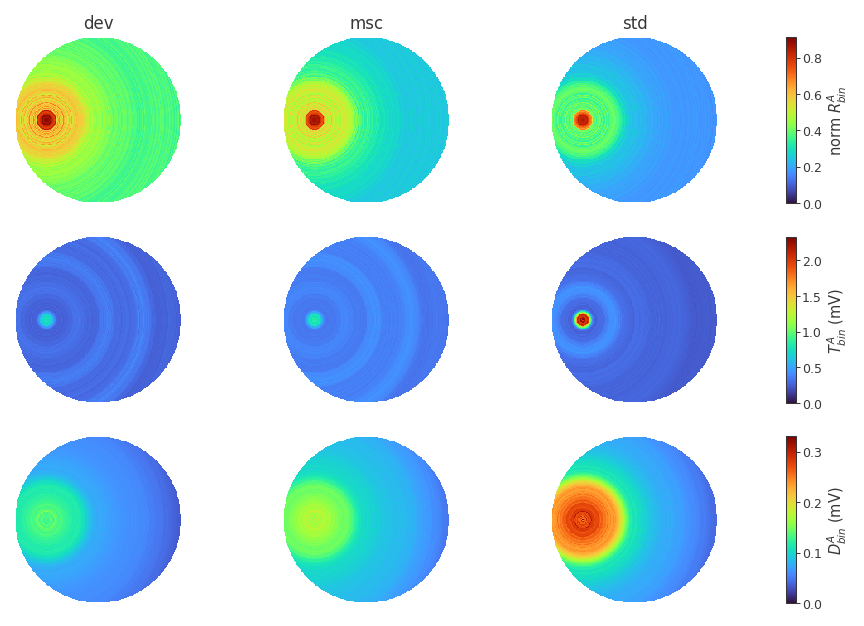

In [7]:
def panel_frac_space(axs, cax, kind='hist', **kwargs):
    data = {'hist': disthist_steady, 'TA': fine_TA_steady, 'STD': fine_STD_steady}[kind]
    divisor = {'hist': disthist_initial, 'TA': mV, 'STD': 1}[kind]
    sz = 100
    meshes = {cond: np.full((2*sz+1, 2*sz+1), np.nan) for cond in conds}
    stimloc = 0, -cfg.params['stim_distribution_radius'] / cfg.params['r_dish']
    for cond in conds:
        histfrac = data[cond] / divisor
        for i in range(-sz, sz+1):
            for j in range(-sz, sz+1):
                if (i/sz)**2 + (j/sz)**2 < 1:
                    d = np.sqrt((stimloc[0] - i/sz)**2 + (stimloc[1] - j/sz)**2) * cfg.params['r_dish']/mm
                    bin = np.digitize(d, distconf['full']['edges'])
                    try:
                        meshes[cond][i+sz,j+sz] = histfrac[bin]
                    except IndexError:
                        continue
    vmax = np.max([np.nanmax(m) for m in meshes.values()])
    for ax, (cond, mesh) in zip(axs, meshes.items()):
        ax.set_aspect('equal')
        m = ax.pcolormesh(mesh, vmin=0, vmax=vmax, cmap='turbo')
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(ax=ax, bottom=True, left=True)
    plt.colorbar(m, cax=cax, label={
        'hist': 'norm $R^A_{bin}$',
        'TA': '$T^A_{bin}$ (mV)',
        'STD': '$D^A_{bin}$ (mV)'}
        [kind], **kwargs)

fig, axgrid = plt.subplots(3, 4, figsize=(7,5), gridspec_kw={'width_ratios': (1,1,1,.04)}, dpi=150)
fig.patch.set_facecolor('w')
for axs, kind in zip(axgrid, ('hist', 'TA', 'STD')):
    panel_frac_space(axs[:-1], axs[-1], kind)
for ax, cond in zip(axgrid[0], conds):
    ax.set_title(cond)

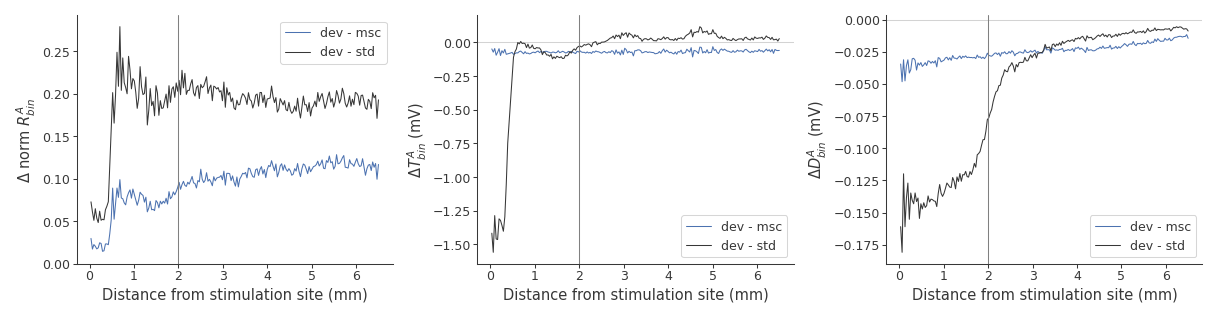

In [8]:
def panel_frac_diff_lines(ax, kind):
    data = {'hist': disthist_steady, 'TA': fine_TA_steady, 'STD': fine_STD_steady}[kind]
    divisor = {'hist': disthist_initial, 'TA': mV, 'STD': 1}[kind]
    for cond in ('msc', 'std'):
        ax.plot(
            distconf['full']['edges'][1:],
            (data['dev'] - data[cond]) / divisor,
            color=pu.colors[cond], label=f'dev - {cond}')
    if kind == 'hist':
        ax.set_ylim(bottom=0)
    else:
        ax.axhline(0, color='lightgrey', zorder=0)
    for edge in distconf['rough']['edges'][1:-1]:
        ax.axvline(edge, color='grey')
    ax.set_xlabel('Distance from stimulation site (mm)')
    ax.set_ylabel({
        'hist': '$\\Delta$ norm $R^A_{bin}$',
        'TA': '$\\Delta T^A_{bin}$ (mV)',
        'STD': '$\\Delta D^A_{bin}$ (mV)'}
        [kind])
    ax.legend()
    sns.despine(ax=ax)

fig, axs = plt.subplots(1,3, figsize=(8,2), dpi=150, layout='constrained')
fig.patch.set_facecolor('w')
for ax, kind in zip(axs, ('hist', 'TA', 'STD')):
    panel_frac_diff_lines(ax, kind)

0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local TA dev < std: T = 482, p = 8.31e-17
local TA dev < msc: T = 831, p = 1.15e-13
global TA dev < msc: T = 1.09e+03, p = 1.37e-11

0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local STD dev < std: T = 735, p = 1.71e-14
local STD dev < msc: T = 1.46e+03, p = 6.13e-09
global STD dev < msc: T = 927, p = 7.27e-13



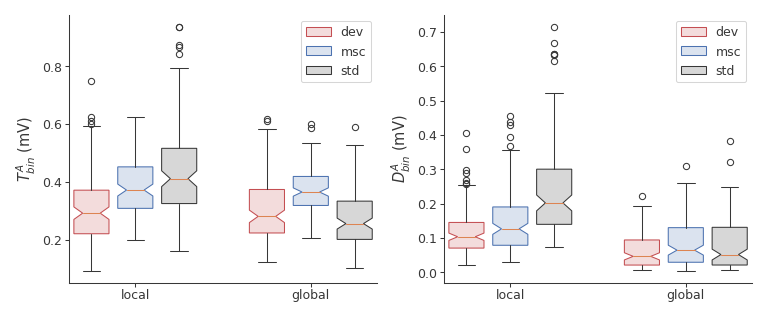

In [9]:
def panel_frac_rough_boxes(ax, kind):
    data = {'hist': distrough_steady_nets, 'TA': rough_TA_steady_nets, 'STD': rough_STD_steady_nets}[kind]
    divisor = {'hist': distrough_initial, 'TA': mV, 'STD': 1}[kind]
    rough = {cond: data[cond] / divisor for cond in conds}
    for i, cond in enumerate(conds):
        patchprops = {'color': pu.colors[cond], 'facecolor': pu.alpha_to_color(pu.colors[cond], .2)}
        ax.boxplot(
            rough[cond], notch=True, positions=np.arange(2) + i/4, widths=.2,
            patch_artist=True, boxprops=patchprops, manage_ticks=False)
        ax.fill_between([],[],[], **patchprops, label=cond)
    ax.set_xticks(
        np.arange(2) + 1/4,
        ['local', 'global'])
    ax.set_ylabel({
        'hist': 'Norm $R^A_{bin}$',
        'TA': '$T^A_{bin}$ (mV)',
        'STD': '$D^A_{bin}$ (mV)'}
        [kind])
    ax.legend()
    sns.despine(ax=ax)

    for i in range(2):
        print(f'{distconf["rough"]["edges"][i]:.1f}~{distconf["rough"]["edges"][i+1]:.1f} mm: '
              f'{roughbase.mean(0)[i]:.1f} +- {roughbase.std(0)[i]:.1f} neurons')
    
    if kind == 'hist':
        for cond in ('msc', 'std'):
            test = stats.wilcoxon(
                rough['dev'][:, 0] - rough[cond][:, 0],
                rough['dev'][:, 1] - rough[cond][:, 1],
                alternative='less'
            )
            print(f'R dev-{cond} local < global: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    else:
        test = stats.wilcoxon(rough['dev'][:, 0], rough['std'][:, 0], alternative='less')
        print(f'local {kind} dev < std: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

        test = stats.wilcoxon(rough['dev'][:, 0], rough['msc'][:, 0], alternative='less')
        print(f'local {kind} dev < msc: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

        test = stats.wilcoxon(rough['dev'][:, 1], rough['msc'][:, 1], alternative='less')
        print(f'global {kind} dev < msc: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    print()

fig, axs = plt.subplots(1,2, figsize=(5,2), dpi=150, layout='constrained')
fig.patch.set_facecolor('w')
for ax, kind in zip(axs, ('TA', 'STD')):
    panel_frac_rough_boxes(ax, kind)


0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local TA dev < std: T = 482, p = 8.31e-17
local TA dev < msc: T = 831, p = 1.15e-13
global TA dev < msc: T = 1.09e+03, p = 1.37e-11

0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local STD dev < std: T = 735, p = 1.71e-14
local STD dev < msc: T = 1.46e+03, p = 6.13e-09
global STD dev < msc: T = 927, p = 7.27e-13



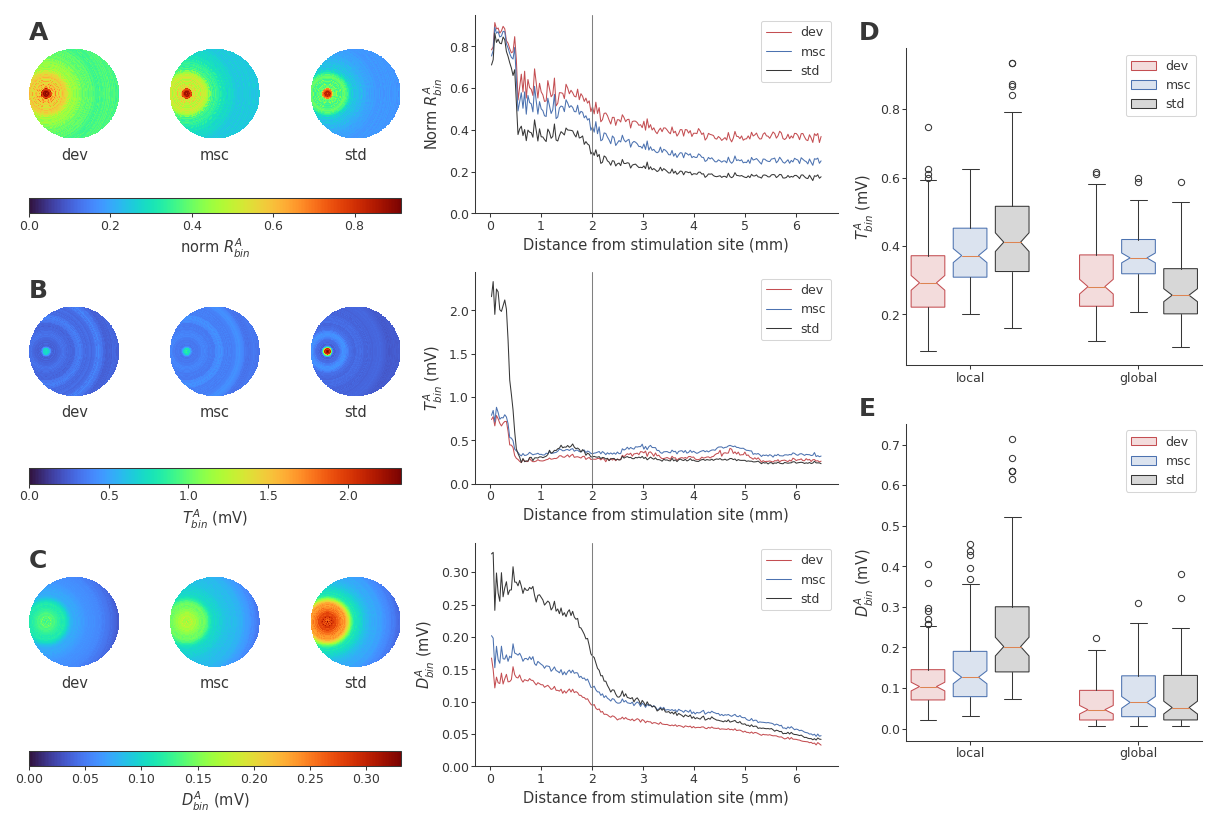

In [10]:
fig = plt.figure(figsize=pu.fullwidth(4.25), layout='compressed', dpi=150)
gs_top = fig.add_gridspec(6, 5, width_ratios=(1,1,1,4,4), height_ratios=(10,1,10,1,10,1))

for row, kind in enumerate(('hist', 'TA', 'STD')):
    axs = [fig.add_subplot(gs_top[2*row, i]) for i in range(3)]
    cax = fig.add_subplot(gs_top[2*row+1, :3])
    panel_frac_space(axs, cax, kind, orientation='horizontal')
    for ax, cond in zip(axs, conds):
        ax.set_xlabel(cond)
    
    if kind == 'hist':
        panel_frac_hist_lines(fig.add_subplot(gs_top[2*row:2*(row+1), 3]))
    else:
        panel_raw_lines(fig.add_subplot(gs_top[2*row:2*(row+1), 3]), kind)
    
    pu.label_panel(axs[0], row)

subfig_right = fig.add_subfigure(gs_top[:, 4])
gs_right = subfig_right.add_gridspec(2)
for row, kind in enumerate(('TA', 'STD')):
    ax = subfig_right.add_subplot(gs_right[row])
    panel_frac_rough_boxes(ax, kind)
    pu.label_panel(ax, row+3)

plt.savefig('paper-1/fig-space-new.pdf')